In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import sklearn
import os
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import os
import glob
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Mel_Spec

In [6]:
data_path = '/home/sangheon/Desktop/ISYE_Final/Data'
genre_base_path = os.path.join(data_path, 'genres_original')
genres = os.listdir(genre_base_path)

output_path = os.path.join(data_path, 'MelSpec')
os.makedirs(output_path, exist_ok=True)

sr = 22050
n_mels = 129
n_fft = 2048
hop_length = 512

for genre in genres:
    genre_dir = os.path.join(genre_base_path, genre)
    genre_output_dir = os.path.join(output_path, genre)
    os.makedirs(genre_output_dir, exist_ok=True)

    for fname in tqdm(os.listdir(genre_dir), desc=f'Processing {genre}'):
        if fname.endswith('.wav'):
            file_path = os.path.join(genre_dir, fname)
            try:
                y, _ = librosa.load(file_path, sr=sr)
                mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
                mel_db = librosa.power_to_db(mel, ref=np.max)

                mel_df = pd.DataFrame(mel_db)
                csv_filename = fname.replace('.wav', '.csv')
                mel_df.to_csv(os.path.join(genre_output_dir, csv_filename), index=False)
            except Exception as e:
                print(f"❌ Failed processing {file_path}: {e}")

Processing jazz:  83%|████████▎ | 83/100 [00:07<00:01,  9.28it/s]/tmp/ipykernel_1658256/2164758392.py:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/home/sangheon/.local/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing jazz:  85%|████████▌ | 85/100 [00:07<00:01, 10.62it/s]

❌ Failed processing /home/sangheon/Desktop/ISYE_Final/Data/genres_original/jazz/jazz.00054.wav: 


Processing hiphop: 100%|██████████| 100/100 [00:10<00:00,  9.37it/s]


## K-Means Clustering 

Loading hiphop: 100%|██████████| 100/100 [00:01<00:00, 66.79it/s]


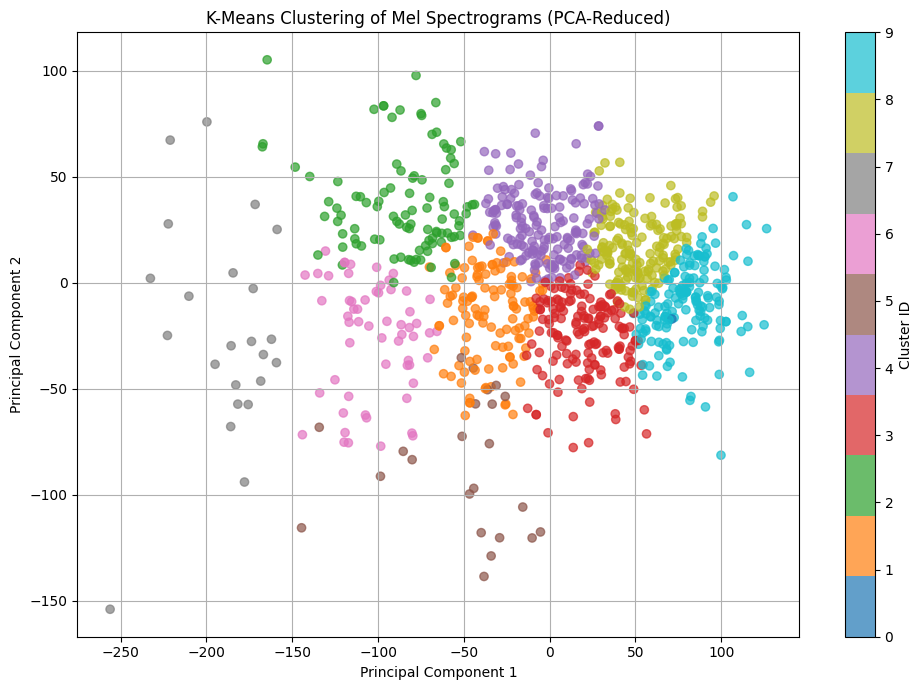

In [ ]:
mel_root = '/home/sangheon/Desktop/ISYE_Final/Data/MelSpec'
genres = os.listdir(mel_root)

fixed_length = 129 * 130

X = []
y_true = []
file_names = []

for genre in genres:
    genre_dir = os.path.join(mel_root, genre)
    for csv_file in tqdm(glob.glob(f'{genre_dir}/*.csv'), desc=f"Loading {genre}"):
        try:
            mel = pd.read_csv(csv_file).values
            mel_flat = mel.flatten()

            if len(mel_flat) >= fixed_length:
                mel_flat = mel_flat[:fixed_length]
            else:
                mel_flat = np.pad(mel_flat, (0, fixed_length - len(mel_flat)))

            X.append(mel_flat)
            y_true.append(genre)
            file_names.append(os.path.basename(csv_file))

        except Exception as e:
            print(f"Failed to read {csv_file}: {e}")

X = np.array(X)

X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.title("K-Means Clustering of Mel Spectrograms (PCA-Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.tight_layout()
plt.show()

Loading hiphop: 100%|██████████| 100/100 [00:01<00:00, 66.47it/s]


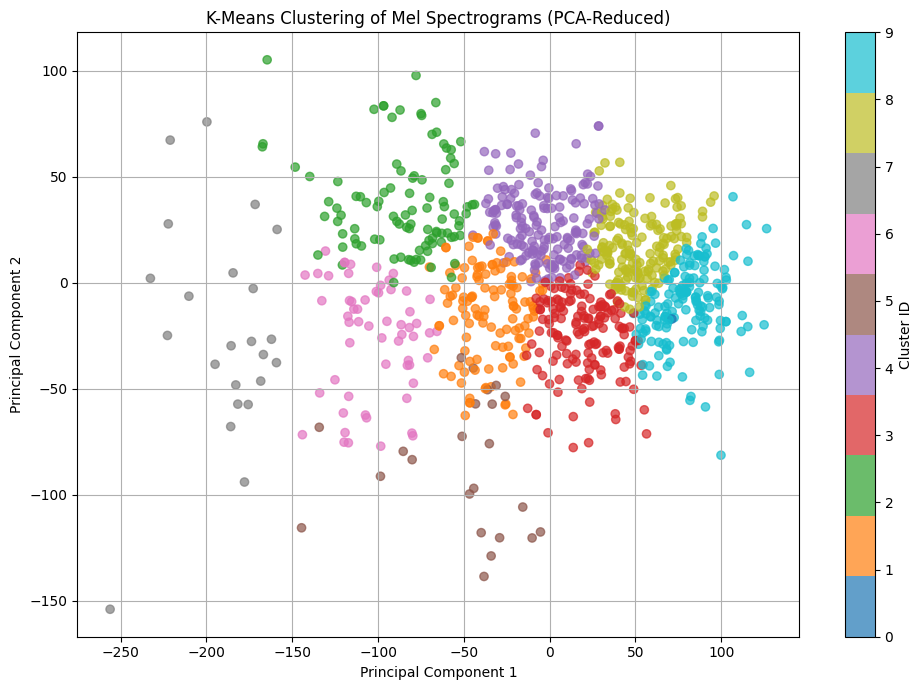


🎧 Top-5 Recommended Songs:
blues.00040.csv (Similarity: 0.7956)
metal.00009.csv (Similarity: 0.7852)
metal.00010.csv (Similarity: 0.7649)
rock.00091.csv (Similarity: 0.7644)
metal.00017.csv (Similarity: 0.7633)


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# ========== 1. 데이터 로딩 및 전처리 ==========
mel_root = '/home/sangheon/Desktop/ISYE_Final/Data/MelSpec'
genres = os.listdir(mel_root)
fixed_length = 129 * 130

X = []
y_true = []
file_names = []

for genre in genres:
    genre_dir = os.path.join(mel_root, genre)
    for csv_file in tqdm(glob.glob(f'{genre_dir}/*.csv'), desc=f"Loading {genre}"):
        try:
            mel = pd.read_csv(csv_file).values
            mel_flat = mel.flatten()
            if len(mel_flat) >= fixed_length:
                mel_flat = mel_flat[:fixed_length]
            else:
                mel_flat = np.pad(mel_flat, (0, fixed_length - len(mel_flat)))
            X.append(mel_flat)
            y_true.append(genre)
            file_names.append(os.path.basename(csv_file))
        except Exception as e:
            print(f"Failed to read {csv_file}: {e}")

X = np.array(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# ========== 2. 시각화 ==========
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.title("K-Means Clustering of Mel Spectrograms (PCA-Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== 3. 입력 오디오 전처리 ==========
def preprocess_audio(audio_path, fixed_length, scaler, pca):
    y, sr = librosa.load(audio_path, sr=16000)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=129)
    mel_db = librosa.power_to_db(mel)
    mel_flat = mel_db.flatten()
    if len(mel_flat) >= fixed_length:
        mel_flat = mel_flat[:fixed_length]
    else:
        mel_flat = np.pad(mel_flat, (0, fixed_length - len(mel_flat)))
    mel_scaled = scaler.transform([mel_flat])
    mel_pca = pca.transform(mel_scaled)
    return mel_scaled, mel_pca

# ========== 4. 추천 함수 ==========
def recommendation(mel_scaled_input, X_scaled_dataset, file_names, clusters, input_cluster, top_k=5):
    candidate_indices = np.where(clusters == input_cluster)[0]
    similarities = cosine_similarity(mel_scaled_input, X_scaled_dataset[candidate_indices])[0]
    top_k_indices = candidate_indices[np.argsort(similarities)[::-1][:top_k]]
    recommended_files = [file_names[i] for i in top_k_indices]
    similarity_scores = [similarities[i] for i in np.argsort(similarities)[::-1][:top_k]]
    return list(zip(recommended_files, similarity_scores))

# ========== 5. 테스트 오디오로 추천 실행 ==========
audio_path = '/home/sangheon/Desktop/ISYE_Final/test_data/Last Dinosaurs - Sense.wav'
mel_input_scaled, mel_input_pca = preprocess_audio(audio_path, fixed_length, scaler, pca)
input_cluster = kmeans.predict(mel_input_scaled)[0]

recommendations = recommendation(
    mel_input_scaled,
    X_scaled,
    file_names,
    clusters,
    input_cluster,
    top_k=5
)

# ========== 6. 결과 출력 ==========
print("\n🎧 Top-5 Recommended Songs:")
for fname, score in recommendations:
    print(f"{fname} (Similarity: {score:.4f})")


## Spectral Clustering 

Loading hiphop: 100%|██████████| 100/100 [00:01<00:00, 72.83it/s]


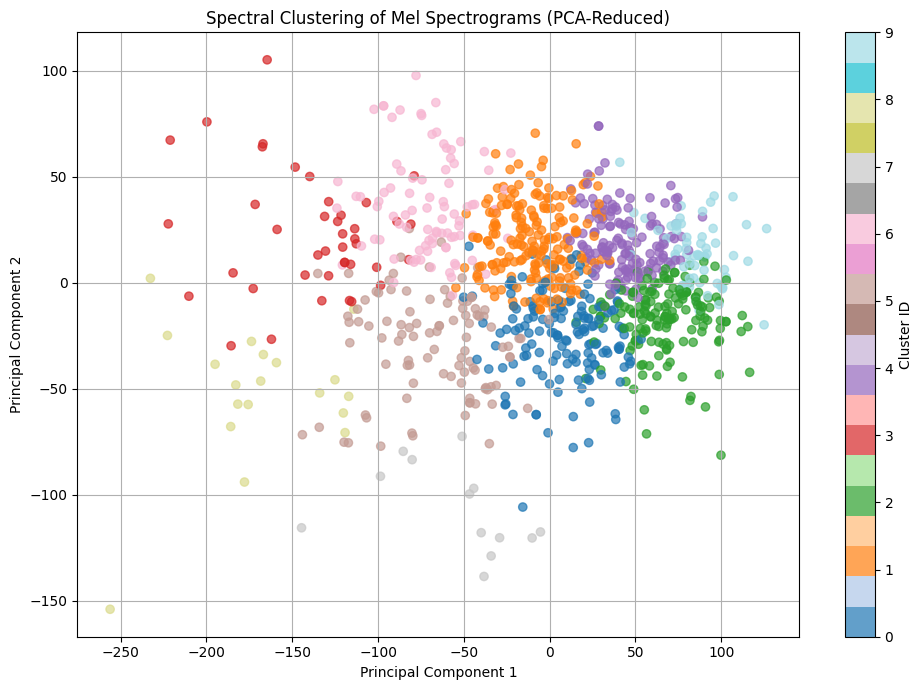

In [9]:
from sklearn.cluster import KMeans, SpectralClustering

mel_root = '/home/sangheon/Desktop/ISYE_Final/Data/MelSpec'
genres = os.listdir(mel_root)

fixed_length = 129 * 130

X = []
y_true = []
file_names = []

for genre in genres:
    genre_dir = os.path.join(mel_root, genre)
    for csv_file in tqdm(glob.glob(f'{genre_dir}/*.csv'), desc=f"Loading {genre}"):
        try:
            mel = pd.read_csv(csv_file).values
            mel_flat = mel.flatten()

            if len(mel_flat) >= fixed_length:
                mel_flat = mel_flat[:fixed_length]
            else:
                mel_flat = np.pad(mel_flat, (0, fixed_length - len(mel_flat)))

            X.append(mel_flat)
            y_true.append(genre)
            file_names.append(os.path.basename(csv_file))

        except Exception as e:
            print(f"Failed to read {csv_file}: {e}")

X = np.array(X)

X_scaled = StandardScaler().fit_transform(X)

kmeans = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', n_neighbors=10)
clusters = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab20', alpha=0.7)
plt.title("Spectral Clustering of Mel Spectrograms (PCA-Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.tight_layout()
plt.show()

## GMM

In [ ]:
from sklearn.cluster import

mel_root = '/home/sangheon/Desktop/ISYE_Final/Data/MelSpec'
genres = os.listdir(mel_root)

fixed_length = 129 * 130

X = []
y_true = []
file_names = []

for genre in genres:
    genre_dir = os.path.join(mel_root, genre)
    for csv_file in tqdm(glob.glob(f'{genre_dir}/*.csv'), desc=f"Loading {genre}"):
        try:
            mel = pd.read_csv(csv_file).values
            mel_flat = mel.flatten()

            if len(mel_flat) >= fixed_length:
                mel_flat = mel_flat[:fixed_length]
            else:
                mel_flat = np.pad(mel_flat, (0, fixed_length - len(mel_flat)))

            X.append(mel_flat)
            y_true.append(genre)
            file_names.append(os.path.basename(csv_file))

        except Exception as e:
            print(f"Failed to read {csv_file}: {e}")

X = np.array(X)

X_scaled = StandardScaler().fit_transform(X)

kmeans = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', n_neighbors=10)
clusters = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab20', alpha=0.7)
plt.title("Spectral Clustering of Mel Spectrograms (PCA-Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.tight_layout()
plt.show()

# Chromagram

In [4]:
data_path = '/home/sangheon/Desktop/ISYE_Final/Data'
genre_base_path = os.path.join(data_path, 'genres_original')
genres = os.listdir(genre_base_path)

output_path = os.path.join(data_path, 'Chromagram')
os.makedirs(output_path, exist_ok=True)

sr = 16000
n_fft = 2048
hop_length = 512

for genre in genres:
    genre_dir = os.path.join(genre_base_path, genre)
    genre_output_dir = os.path.join(output_path, genre)
    os.makedirs(genre_output_dir, exist_ok=True)

    for fname in tqdm(os.listdir(genre_dir), desc=f'Processing {genre}'):
        if fname.endswith('.wav'):
            file_path = os.path.join(genre_dir, fname)
            try:
                y, _ = librosa.load(file_path, sr=sr)
                chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
                chroma_df = pd.DataFrame(chroma)
                csv_filename = fname.replace('.wav', '.csv')
                chroma_df.to_csv(os.path.join(genre_output_dir, csv_filename), index=False)
            except Exception as e:
                print(f"Failed processing {file_path}: {e}")

Processing jazz:  82%|████████▏ | 82/100 [00:07<00:01, 13.12it/s]/tmp/ipykernel_1655566/3041360343.py:21: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=sr)
/home/sangheon/.local/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing jazz:  86%|████████▌ | 86/100 [00:07<00:01, 13.03it/s]

Failed processing /home/sangheon/Desktop/ISYE_Final/Data/genres_original/jazz/jazz.00054.wav: 


Processing hiphop: 100%|██████████| 100/100 [00:10<00:00,  9.37it/s]


Loading hiphop: 100%|██████████| 100/100 [00:00<00:00, 176.51it/s]


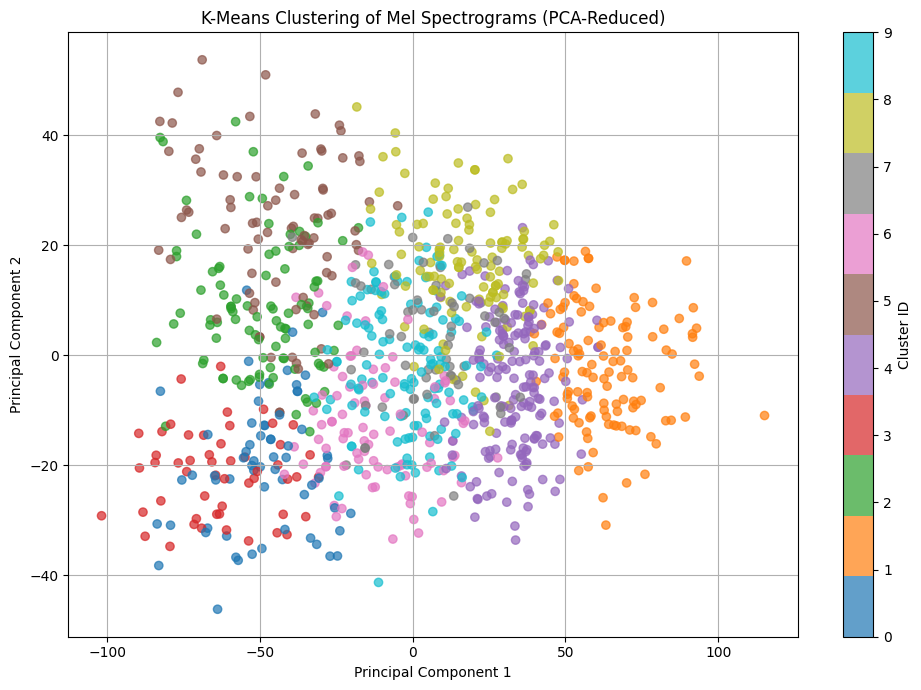

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

mel_root = '/home/sangheon/Desktop/ISYE_Final/Data/Chromagram'
genres = os.listdir(mel_root)

fixed_length = 129 * 130

X = []
y_true = []
file_names = []

for genre in genres:
    genre_dir = os.path.join(mel_root, genre)
    for csv_file in tqdm(glob.glob(f'{genre_dir}/*.csv'), desc=f"Loading {genre}"):
        try:
            mel = pd.read_csv(csv_file).values
            mel_flat = mel.flatten()

            if len(mel_flat) >= fixed_length:
                mel_flat = mel_flat[:fixed_length]
            else:
                mel_flat = np.pad(mel_flat, (0, fixed_length - len(mel_flat)))

            X.append(mel_flat)
            y_true.append(genre)
            file_names.append(os.path.basename(csv_file))

        except Exception as e:
            print(f"Failed to read {csv_file}: {e}")

X = np.array(X)

X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.title("K-Means Clustering of Mel Spectrograms (PCA-Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.tight_layout()
plt.show()